In [1]:
#import os
#import cv2
import skimage.io
from tqdm.notebook import tqdm
#import zipfile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

In [2]:
from pathlib import Path
PATH = Path("../data")

In [3]:
labels = pd.read_csv(PATH/'train_labels.csv')
labels.head(3)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4


In [4]:
# path2 = Path('../data/train')
# files = [str(p) for p in path2.iterdir()]

# to_concat= []
# for i,row in labels.iterrows():
#     full_file = '../data/train/' + row['image_id'] + '_0.png'
#     if full_file in files:
#         to_concat.append(pd.DataFrame(row))

# labels = pd.concat(to_concat, axis=0)


In [5]:
# labels = pd.concat([tc.T for tc in to_concat])

In [6]:
# labels.loc[labels['image_id'] == 'ffe9bcababc858e04840669e788065a1']

In [7]:
# labels.to_csv(PATH/'train_labels_clean.csv', index=False)

In [8]:
labels = pd.read_csv(PATH/'train_labels_clean.csv')

In [9]:
example = ['ffe9bcababc858e04840669e788065a1_0.png', 
           'ffe9bcababc858e04840669e788065a1_1.png',
           'ffe9bcababc858e04840669e788065a1_10.png', 
           'ffe9bcababc858e04840669e788065a1_11.png',
            'ffe9bcababc858e04840669e788065a1_12.png',
            'ffe9bcababc858e04840669e788065a1_13.png',
            'ffe9bcababc858e04840669e788065a1_13.png',
            'ffe9bcababc858e04840669e788065a1_14.png',
            'ffe9bcababc858e04840669e788065a1_15.png',
            'ffe9bcababc858e04840669e788065a1_2.png',
            'ffe9bcababc858e04840669e788065a1_3.png',
            'ffe9bcababc858e04840669e788065a1_4.png',
            'ffe9bcababc858e04840669e788065a1_5.png',
            'ffe9bcababc858e04840669e788065a1_6.png',
            'ffe9bcababc858e04840669e788065a1_7.png',
            'ffe9bcababc858e04840669e788065a1_8.png',
            'ffe9bcababc858e04840669e788065a1_9.png']

In [10]:
def read_file(filename):
    '''return array representing image'''
    return skimage.io.imread(PATH/f'train/{filename}')

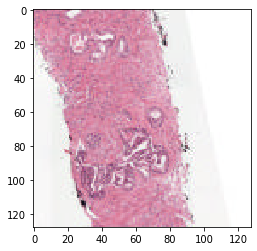

In [11]:
plt.imshow(read_file(example[10]))

In [12]:
X_train, X_val, y_train, y_val = train_test_split(labels['image_id'].values, 
                                                  labels['isup_grade'].values, test_size=0.2, random_state=42)

In [13]:
class PANDADataset(Dataset):
    def __init__(self, X, y):
        files = []
        for i in range(len(X)):
            try:
                files.append(np.concatenate(np.array([read_file(X[i] + '_' + str(j) + '.png') 
                          for j in range(16)])))
            except:
                y.pop()
        self.x = files
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_ds = PANDADataset(X_train, y_train)
valid_ds = PANDADataset(X_val, y_val)

In [14]:
np.concatenate(np.array([read_file('ffe9bcababc858e04840669e788065a1' + '_' + str(i) + '.png') 
                          for i in range(16)])).shape

(2048, 128, 3)

In [15]:
x, y = next(iter(train_ds))
x.shape

(2048, 128, 3)

In [16]:
xx = np.rollaxis(x, 2)
xx.shape

(3, 2048, 128)

In [17]:
X = torch.Tensor(xx)
X.shape

torch.Size([3, 2048, 128])

In [18]:
X = X.unsqueeze(0)
X.shape

torch.Size([1, 3, 2048, 128])

In [19]:
conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1)
x = conv1(X)
x.shape

torch.Size([1, 24, 2046, 126])

In [20]:
pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
x = pool1(x)
x.shape

torch.Size([1, 24, 1023, 63])

In [21]:
conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1)
x = conv2(x)
x.shape

torch.Size([1, 32, 1021, 61])

In [22]:
pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
x = pool2(x)
x.shape

torch.Size([1, 32, 510, 30])

In [23]:
32 * 510 * 30

489600

In [24]:
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=5)

In [25]:
class PANDACNN(nn.Module):
    
    def __init__(self):
        super(PANDACNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=24, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=24, out_channels=32, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(489600, 6)
        
    def forward(self, x):
        x = x.cpu().numpy()
        x = np.rollaxis(x, 3, 1)
        x = torch.Tensor(x).cuda().float()
        #x = x.unsqueeze(0)
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        return x#torch.argmax(x) + 1

In [26]:
def quadratic_weighted_kappa(out, y):
    pass

In [27]:
def valid_metrics(model):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0
    for x, y in valid_dl:
        x = x.long().cuda()
        y = y.long().cuda()
        batch = y.shape[0]
        out = model(x)
        #y_hat = quadratic_weighted_kappa(out, y)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
        pred = torch.argmax(out, axis=1).float()
        correct += (pred == y).float().sum().item()
    val_loss = sum_loss/total
    val_acc = correct/total
    return val_loss, val_acc

In [28]:
def train_epocs(model, optimizer, epochs=10):
    for i in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            x = x.long().cuda()
            y = y.long().cuda()
            out = model(x)
            
            #y_pred = quadratic_weighted_kappa(out, y)
            loss = F.cross_entropy(out, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += x.size(0)*loss.item()
            total += x.size(0)
        train_loss = total_loss/total
        val_loss, val_accuracy = valid_metrics(model)
        
        print("train_loss %.3f val_loss %.3f val_accuracy %.3f" % (
            train_loss, val_loss, val_accuracy))

In [29]:
model = PANDACNN().cuda()

In [30]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
train_epocs(model, optimizer, epochs=10)

train_loss 150.864 val_loss 1.708 val_accuracy 0.281
train_loss 1.719 val_loss 1.709 val_accuracy 0.281
train_loss 1.719 val_loss 1.709 val_accuracy 0.281
train_loss 1.719 val_loss 1.708 val_accuracy 0.281
train_loss 1.719 val_loss 1.710 val_accuracy 0.250
train_loss 1.719 val_loss 1.709 val_accuracy 0.281
train_loss 1.719 val_loss 1.709 val_accuracy 0.250
train_loss 1.719 val_loss 1.709 val_accuracy 0.281
train_loss 1.719 val_loss 1.710 val_accuracy 0.250
train_loss 1.720 val_loss 1.709 val_accuracy 0.281
